# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.utils import plot_model
import numpy as np
import os

# Download dataset

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mishahrysiuk","key":"238d13e4e312b69b5d208ad484fd5fec"}'}

In [6]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download samuelcortinhas/sports-balls-multiclass-image-classification
! mkdir sports-balls-multiclass-image-classification
! unzip sports-balls-multiclass-image-classification.zip -d sports-balls-multiclass-image-classification
PATH = "sports-balls-multiclass-image-classification"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_182.jpg  
  inflating: sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_183.jpg  
  inflating: sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_185.jpg  
  inflating: sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_186.jpg  
  inflating: sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_187.jpg  
  inflating: sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_189.jpg  
  inflating: sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_19.jpg  
  inflating: sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_190.jpg  
  inflating: sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_191.jpg  
  inflating: sports-balls-multicl

# Set constants

In [21]:
BATCH_SIZE = 32
IMG_SIZE = 200
EPOCHS = 10

# Preparing train and test datasets

In [8]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'test')

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=(IMG_SIZE, IMG_SIZE))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=(IMG_SIZE, IMG_SIZE))

val_batches = tf.data.experimental.cardinality(validation_dataset)

test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Found 7328 files belonging to 15 classes.
Found 1841 files belonging to 15 classes.


# Show dataset

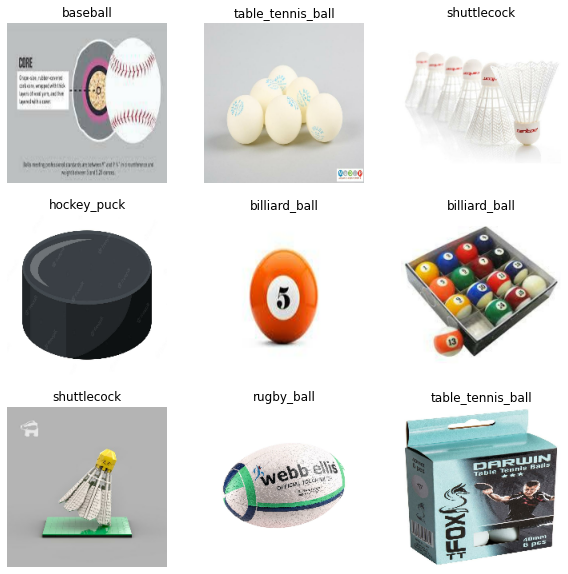

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_dataset = configure_for_performance(train_dataset)
validation_dataset = configure_for_performance(validation_dataset)

# Use data augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1),
])

# Defining Classification Model

In [18]:
def CNN_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3,))
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(642, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.models.Model(input_, output_, name='CNN_model')

def CNN_model_1(num_classes):
    input_ = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3,))
    x = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(input_)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.models.Model(input_, output_, name='CNN_model_1')

def CNN_model_2(num_classes):
    input_ = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3,))
    x = data_augmentation(input_)
    x = tf.keras.layers.Rescaling(1./255)(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.models.Model(input_, output_, name='CNN_model_2')

def CNN_model_EfficientNet(num_classes):
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",
                                                                   input_shape=(IMG_SIZE, IMG_SIZE, 3,), pooling='max')
    base_model.trainable = True

    x = base_model.output
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=.4, seed=123)(x)       
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.models.Model(inputs=base_model.input, outputs=output, name='CNN_model_EfficientNet')

num_classes = len(class_names)
model = CNN_model_EfficientNet(num_classes)
model.summary()


Model: "CNN_model_EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 200, 200, 3)  0           ['input_7[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 200, 200, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                             

# View block diagram of the model

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.75985 to fit



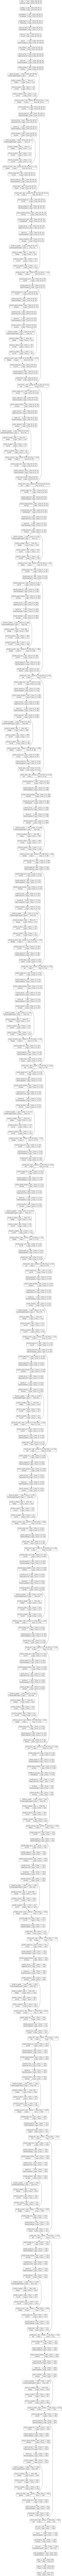

In [19]:
plot_model(model, show_shapes=True, expand_nested=True)

# Model compile

In [22]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

history = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset)


Epoch 1/10
229/229 [==============================] - 2029s 9s/step - loss: 1.5155 - accuracy: 0.6201 - val_loss: 4.9140 - val_accuracy: 0.6723
Epoch 2/10
229/229 [==============================] - 2103s 9s/step - loss: 1.0116 - accuracy: 0.7417 - val_loss: 1.1424 - val_accuracy: 0.7300
Epoch 3/10
229/229 [==============================] - 2042s 9s/step - loss: 0.5930 - accuracy: 0.8360 - val_loss: 0.7382 - val_accuracy: 0.8355
Epoch 4/10
229/229 [==============================] - 2023s 9s/step - loss: 0.4286 - accuracy: 0.8792 - val_loss: 0.7632 - val_accuracy: 0.8026
Epoch 5/10
229/229 [==============================] - 2037s 9s/step - loss: 0.3013 - accuracy: 0.9165 - val_loss: 0.8054 - val_accuracy: 0.8334
Epoch 6/10
229/229 [==============================] - 2039s 9s/step - loss: 0.3195 - accuracy: 0.9112 - val_loss: 1.1103 - val_accuracy: 0.8408
Epoch 7/10
229/229 [==============================] - 2058s 9s/step - loss: 0.2516 - accuracy: 0.9300 - val_loss: 0.6678 - val_accuracy:

# Evaluate models

In [23]:
metrics = model.evaluate(train_dataset, batch_size=BATCH_SIZE, verbose=0)
metric_names = ['Train loss', 'Train Accuracy']

for name, value in zip(metric_names, metrics):
    print(f'{name} : {value}')
    
metrics = model.evaluate(validation_dataset, batch_size=BATCH_SIZE, verbose=0)
metric_names = ['Val loss', 'Val Accuracy']

for name, value in zip(metric_names, metrics):
    print(f'{name} : {value}')
    
metrics = model.evaluate(test_dataset, batch_size=BATCH_SIZE, verbose=0)
metric_names = ['Test loss', 'Test Accuracy']

for name, value in zip(metric_names, metrics):
    print(f'{name} : {value}')

Train loss : 0.7471831440925598
Train Accuracy : 0.8790938854217529
Val loss : 1.2720297574996948
Val Accuracy : 0.7683008909225464
Test loss : 1.2682145833969116
Test Accuracy : 0.7727272510528564


# Plotting train, test losses and accuracy

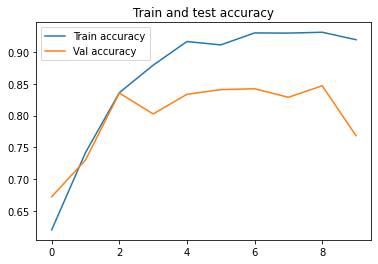

<Figure size 7200x7200 with 0 Axes>

In [24]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
plt.title('Train and test accuracy')
plt.legend()
plt.figure(figsize = (100,100))
plt.show()

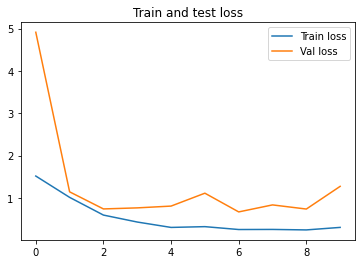

<Figure size 14400x14400 with 0 Axes>

In [25]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('Train and test loss')
plt.legend()
plt.figure(figsize = (200,200))
plt.show()